### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from commons.optimizer import eficient_SBSR
from scipy.optimize import minimize
from commons.objFunc import objf3D

from scipy.interpolate import BSpline

from ComparisonFunctions.ComparisonFunctions import fieldOfViewCompare
import timeit

### Define functions

In [2]:
d_bar = 5000
lambda0, dmax, k = 0.005, 8, 2

tol = 1e-3
options  ={'disp': False, 'maxiter': 5000}

def readfile(file_dir):
    LoRs = pd.read_csv(file_dir, header=None, sep='\s+').to_numpy()
    LoRs = LoRs[LoRs[:, 0].argsort()]
    return LoRs[:, [1, 2, 3, 0, 5, 6, 7, 4]]

def processData(LoRs, N=0):
    times = LoRs[:, 3]
    P1, P2 = LoRs[:, 0:3].T , LoRs[:, 4:7].T

    if not N:
        N = int(len(times) / d_bar) + 1
    A = np.zeros((3, N))
    B = np.zeros((3, N))
    
    tc1, tc2 = times[0], times[-1]
    T = np.linspace(tc1, tc2, N - 1)
    knots = np.r_[[0]*k, T, [T[-1]]*k]

    return times, P1, P2, N, A, B, tc1, tc2, knots

def predictSpline(X, tc1, tc2, knots, k):
    s_x, s_y, s_z = X.reshape((3, -1))

    Nr = 1000
    te = np.linspace(tc1, tc2, Nr)

    spl_x = BSpline(knots, s_x, k)
    spl_y = BSpline(knots, s_y, k)
    spl_z = BSpline(knots, s_z, k)
    return [te * 1000, spl_x(te), spl_y(te), spl_z(te)]

### Read & Process benchmarking data

In [3]:
FOV_ADAC = []
file_dir = f"data/FOV_ADAC_finalCoinc.dat"
LoRs = readfile(file_dir)
times, P1, P2, N, A, B, tc1, tc2, knots = processData(LoRs)

### Compare reconstruction speed and accuracy of previous & current algorithms

In [4]:
start_time = timeit.default_timer()
X = eficient_SBSR(A, LoRs, N, k, knots, lambda0, dmax, options=options, tol=tol).x
print("Current algorithm:\nReconstruction time:", timeit.default_timer() - start_time, "s")

preds = predictSpline(X, tc1, tc2, knots, k)
compare = fieldOfViewCompare(np.array(preds).T)
print("RMS Error:", compare[2].mean(), "mm\n")
FOV_ADAC.append(compare[2])


start_time = timeit.default_timer()
Y = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax, lambda0), B, method='BFGS', options=options, tol=tol).x
print("Previous algorithm:\nReconstruction time:", timeit.default_timer() - start_time, "s")

preds = predictSpline(Y, tc1, tc2, knots, k)
compare = fieldOfViewCompare(np.array(preds).T)
print("RMS Error:", compare[2].mean(), "mm\n")
FOV_ADAC.append(compare[2])

Current algorithm:
Reconstruction time: 4.61954280000009 s
RMS Error: 0.8223056564008354 mm



C:\Users\Programming\AppData\Local\Temp\ipykernel_4268\3053926938.py:12: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  Y = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax, lambda0), B, method='BFGS', options=options, tol=tol).x


Previous algorithm:
Reconstruction time: 315.2128296000001 s
RMS Error: 0.8730877006835651 mm



### Plot errors as a function of position in the ADAC scanner

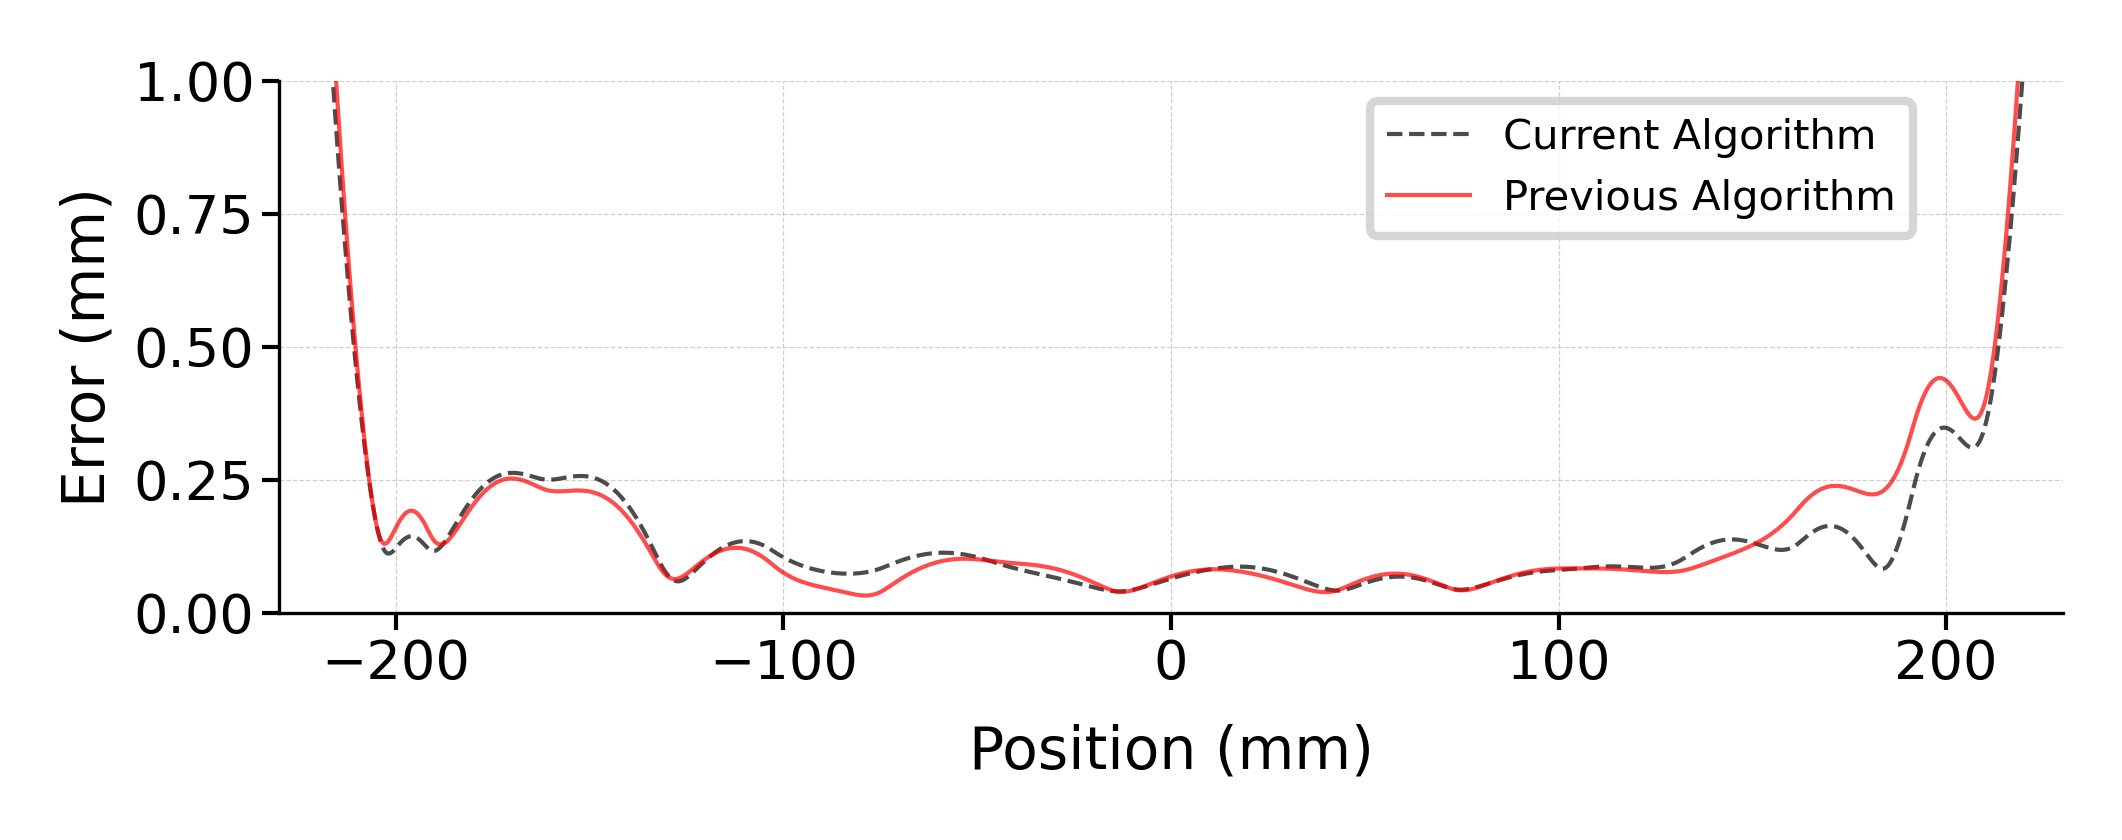

In [5]:
fig, ax = plt.subplots(figsize=(3.58, 1.5), dpi=600)

# plt.rcParams['text.usetex'] = False
# plt.rcParams["font.family"] = "sans-serif" 
# plt.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Cambria"]  # Prioritize Arial and Helvetica
# plt.rcParams["font.size"] = 8
# plt.rcParams['axes.edgecolor'] = '#333F4B'
# plt.rcParams['axes.linewidth'] = 0.8

x_values = np.linspace(-250, 250, 1000)
ax.plot(x_values, FOV_ADAC[0], linestyle="--", color='black', label='Current Algorithm', linewidth=0.5, alpha=0.7)
ax.plot(x_values, FOV_ADAC[1], linestyle="-", color='red', label='Previous Algorithm', linewidth=.5, alpha=0.7)

# Labels
ax.set_ylabel('Error (mm)', fontsize=7, labelpad=2)
ax.legend(loc='upper left', fontsize=5, bbox_to_anchor=(0.6, 1))
ax.set_xlabel("Position (mm)", fontsize=7)
ax.set_xlim([-230, 230])

# Legend
ax.grid(True, which='both', linestyle='--', linewidth=0.15, alpha=0.6)
ax.set_ylim([0, 1])

# Aesthetics 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.tick_params(axis='both', width=0.5, labelsize=6.5, length=2, pad=1)
ax.tick_params(axis='both', which='minor', length=1, width=0.4)

plt.tight_layout()
plt.show()